# *NuSTAR* light curve analysis workbook

This notebook will go through my analysis workflow for computing time- and frequency-domain products of *NuSTAR* light curves. We start by importing the required `Python` modules as well as a custom set of classes and functions from `classes_for_lightcurves.py` that contain methods for performing all of the computations related to the analysis of the light curve data.

In [1]:
from classes_for_lightcurves import *
%matplotlib inline

# Light curve data

The first thing we need to do is read in the data. To handle light curve data and frequently performed tasks on such data, I've created a `LightCurve` class that can be initialized by feeding the `.readFITS` method source (actually total, i.e. source+background) and background FITS light curve files (`srcFile` and `bkgFile` parameters, respectively) that were produced by the `nuproducts` task included in HEASoft. Since *NuSTAR* actually has two identical detector modules, FPMA and FPMB, we will have $2N$ light curves to work with, where $N$ is the number of energy bands that we are analysing. The data we'll be starting with is taken over a broad band high-energy X-ray band, specifically 3.4-50 keV. Since the FPMs on *NuSTAR* are not always observing at peak (100%) efficiency, we'll filter the data to include only those times that *do* correspond to peak efficiency by using `.clean`. We'll then merge the data from FPMA and FPMB using `merge_LightCurves` before binning up in time using `.bin` to increase our signal-to-noise ratio.

83 data points were                       cleaned from the FPMA data
84 data points were                       cleaned from the FPMB data


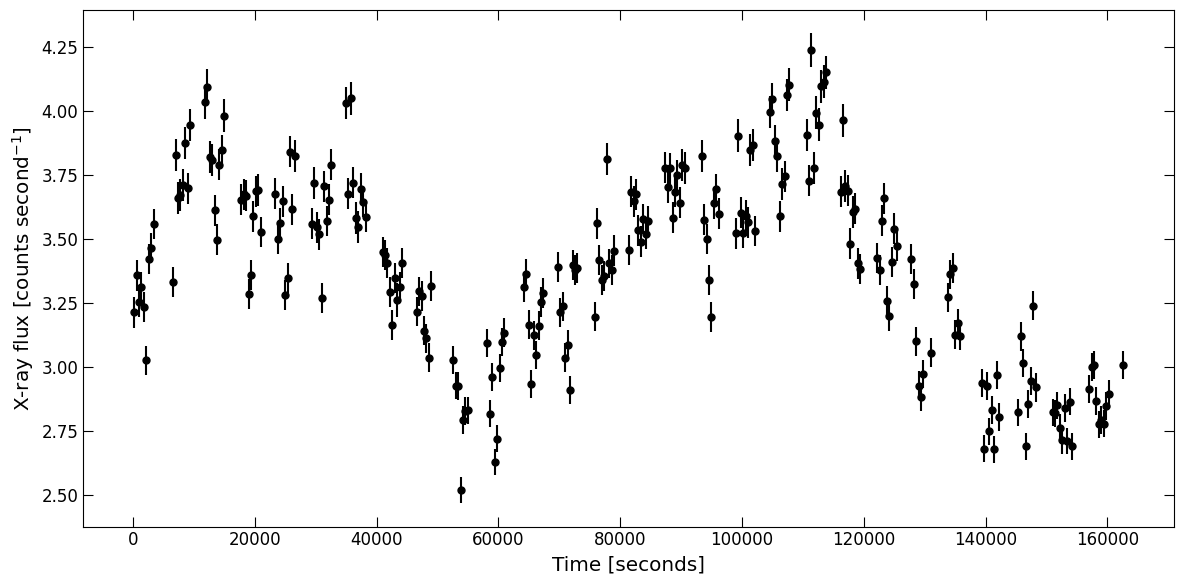

In [2]:
# Read in the FPMA data
bblc_A = LightCurve()
bblc_A.readFITS(srcFile='all_lcs/45_1210_A_sr.lc', bkgFile='all_lcs/45_1210_A_bk.lc')

# Read in the FPMB data
bblc_B = LightCurve()
bblc_B.readFITS(srcFile='all_lcs/45_1210_B_sr.lc', bkgFile='all_lcs/45_1210_B_bk.lc')

# Clean the data
min_fracexp = 1.0
bblc_A.clean(min_fracexp=min_fracexp)
bblc_B.clean(min_fracexp=min_fracexp)

# Merge the FPMA and FPMB data (sum the count rates)
bblc = merge_LightCurves(bblc_A, bblc_B)

# Bin the merged light curve to increase signal-to-noise ratio
dt = 400
bblc.bin(dt=dt)

# Plot the light curve
bblc.plot()

Looking at our cleaned, merged, and binned broad band X-ray light curve above, it is clear that this source is highly variable on various time-scales. This is great, because otherwise we wouldn't have much else to investigate in the time- and frequency-domains, instead being limited to investigating time-average properties, which in my opinion aren't as interesting!

# Gaussian process regression

The first frequency-domain product that we'll look at is the power spectral density (PSD). This product involves performed a Fourier transform on a given time-series. *NuSTAR*, however, orbits the Earth every ~90 minutes, thus imposing regular gaps in the captured light curves. This is very problematic when it comes to Fourier techniques, as those methods require continuous time-series data. To get around this, we must interpolate over the gaps in an *informed* manner. I stress *informed* because the simplest interpolation method would be to just 'connect-the-dots' over the gaps and call it a day. However, the light curve above is clearly variable on time-scales shorter than 90 minutes. Therefore, interpolating over such time-scales in an uninformed manner would introduce variability behaviour inconsistent with the rest of the light curve data, thereby introducing additional noise or even spurious signals that will invalidate subsequent frequency-domain analyses. Our silver-bullet to get around this issue is to use Gaussian process regression. This machine learning technique will optimize the hyperparameters of a given kernel function by training itself on the *observed* portion of the light curve, thus allowing us to sample the over the gaps in an *informed* way. Current X-ray literature on AGN light curves has found that rational quadratic kernels perform best in terms of reproducing AGN X-ray light curves, so that's what I've used here. The Gaussian process regression can be invoked by simply calling `.fit_gp` on the `LightCurve` object. Note that finer binning schemes will ***significantly*** increase the run-time of this step. The time binning should be selected to be as fine as possible while still maintaining a good signal-to-noise ratio. For our purposes, binning to 400 seconds as above will be sufficient. With our Gaussian process regression complete, we can produce a continuously sampled light curve by calling `.sample_gp` and plot it alongside our observed light curve for comparison.

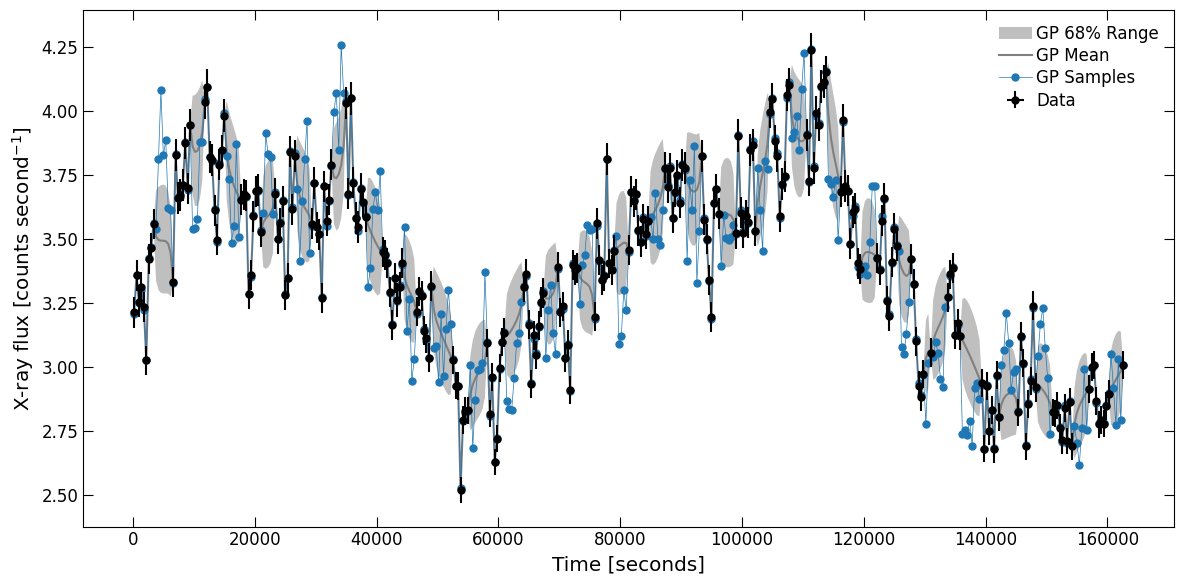

In [3]:
bblc.fit_gp()
bblc.sample_gp(nsamples=1)
bblc.plot()

Visually, it is clear that the sample light curve behaves similarly to the observed one in the gaps. Of course, so quantification of the degree of similarity between the two would be good to do, which I leave for myself as a future improvement to this workbook.

# Power spectral density

(Insert section about PSD.)

# Lag-frequency spectrum

With the PSD analysed, we can now move on to a more complex and informative quantity: the lag-frequency spectrum. Similarly to how we computed the PSD, we can now compute the cross-spectral power ($C$) between a pair of light curves $x\left(t\right)$ and $y\left(t\right)$. If the light curves are linearly correlated with some phase-shift $\phi$ between them, we can use the complex polar representation of their Fourier transforms $X$ and $Y$, for $x\left(t)\right)$ and $y\left(t\right)$, respectively, to compute $C_{\mathrm{XY}}=X^{*}Y=A_{\mathrm{X}}\exp\left[i\psi\right]A_{\mathrm{Y}}\exp\left[i\left(\psi+\phi\right)\right]=A_{\mathrm{X}}A_{\mathrm{Y}}\exp\left[i\phi\right]$, where $A$ is the corresponding Fourier amplitude. The time-lag between $x\left(t\right)$ and $y\left(t\right)$ at a given frequency $\nu$ can then be computed as $\tau\left(\nu\right)=\arg\left[C_{\mathrm{XY}}\left(\nu\right)\right]/2\pi\nu$. In practice, it is best to compute the time-lag within some broad frequency range, which should be done by binning the cross-spectrum in frequency-space, then computing the relevant time-lag. 

The `CrossSpectrum` class and corresponding methods perform the procedure described above by taking a pair of `LightCurve` objects as input. Here, our pair will be comprised of a power law dominated and Fe emission dominated set of light curves in order to compute the time-lag associated with X-ray reverberation off of the inner accretion disc. It is important to stress that it is only possible to do this with *NuSTAR* data, or any other gappy light curve data, *after* we have interpolated over the observing gaps in the light curve. Our use of Gaussian process regression ensures that the interpolated parts of the light curve are as realistic as possible. We can now compute the resultant lag-frequency spectrum between the power law and Fe light curves.

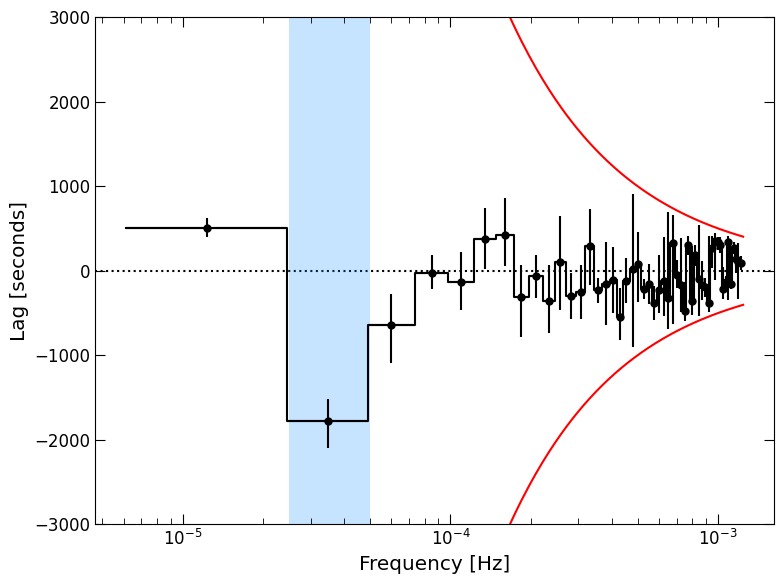

In [4]:
# Produce the power law lght curve and GP samples
pllc_A = LightCurve()
pllc_A.readFITS(srcFile='all_lcs/po_A_sr.lc', bkgFile='all_lcs/po_A_bk.lc')
pllc_B = LightCurve()
pllc_B.readFITS(srcFile='all_lcs/po_B_sr.lc', bkgFile='all_lcs/po_B_bk.lc')
pllc_A.clean(min_fracexp=min_fracexp, msg=False)
pllc_B.clean(min_fracexp=min_fracexp, msg=False)
pllc = merge_LightCurves(pllc_A, pllc_B)
pllc.bin(dt=dt)
pllc.fit_gp(hyperparameters=bblc.gp_hyperparameters)


# Produce the Fe lght curve and GP samples
Felc_A = LightCurve()
Felc_A.readFITS(srcFile='all_lcs/Fe_A_sr.lc', bkgFile='all_lcs/Fe_A_bk.lc')
Felc_B = LightCurve()
Felc_B.readFITS(srcFile='all_lcs/Fe_B_sr.lc', bkgFile='all_lcs/Fe_B_bk.lc')
Felc_A.clean(min_fracexp=min_fracexp, msg=False)
Felc_B.clean(min_fracexp=min_fracexp, msg=False)
Felc = merge_LightCurves(Felc_A, Felc_B)
Felc.bin(dt=dt)
Felc.fit_gp(hyperparameters=bblc.gp_hyperparameters)

# Compute the cross spectrum, and then lag-frequency spectrum
pllc.sample_gp(nsamples=1000)
Felc.sample_gp(nsamples=1000)
cs = CrossSpectrum(Felc, pllc)
cs.lagfreq_spectrum(start_idx=3, num_points=4)
min_freq = 2.5e-5
max_freq = 5.0e-5
cs.plot_lagfreq(min_freq=min_freq, max_freq=max_freq, plot_gp_samples=False, plot_allfreqs=False, yrange=3e3)

In the above lag-frequency spectrum, we see clear evidence of X-ray reverberation in the $\nu\in\left[2.5,5.0\right]\times10^{-5}~\mathrm{Hz}$ frequency range, which I've highlighted as the blue shaded region. I've also included the phase-wrapping limits of $\tau=\pm1/2\nu$ as the red curves. The negative lags indicate that coherent power law band variations *lead* the Fe band ones, while positive lags indicate that coherent Fe band variations *lead* the power law band ones.

Next, we can investigate how the lags in this frequency range evolve as a function of photon energy.

# Lag-energy spectrum

While producing the lag-energy spectrum invovles the most computational effort by far, all of the conceptual and methodological background has been covered above. All we really need to do is compute the lag in a desired frequency range between some reference band and each band of interest, and then plot the results as a function of each bands energy - voila, a lag-energy spectrum! I've created a `LagEnergySpectrum` class that combines all of the methods outlined above for ease-of-use. Basically, the only thing that is new here is that since we're using a reference band of 3.4-50 keV, every other band of interest will be contained within it. Therefore, before computing the lag products using the reference and band of interest pair of light curves, we'll subtract the band of interest out of the reference.

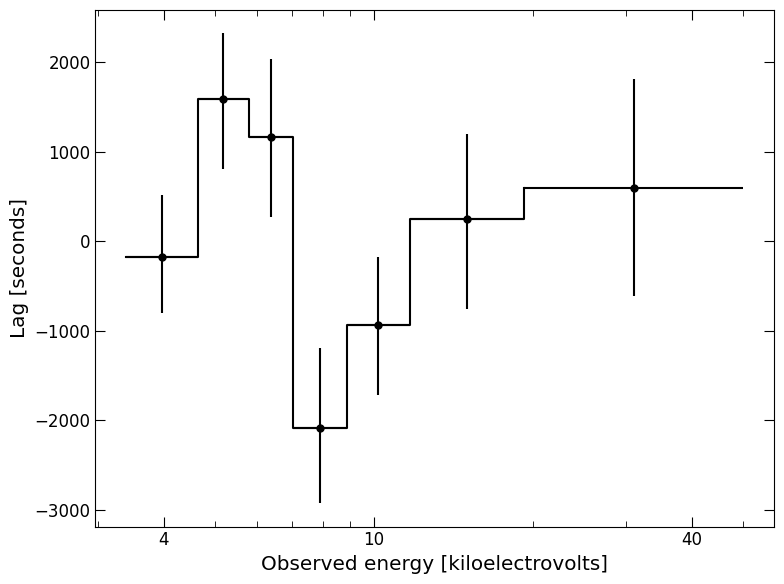

In [5]:
lagenergy = LagEnergySpectrum()
lagenergy.loadLightCurves(refFile="all_lcs/reflc_bin.dat", ciFile="all_lcs/laglcs_bins.dat", inDir="all_lcs", dt=400, n_gp_samples=1000)
lagenergy.compute_lag(min_freq=2.5e-5, max_freq=5.0e-5)
lagenergy.plot()

The above lag-energy spectrum is ***very*** interesting! You can read the plot from a bottom-up approach on the y-axis. We see that 7-9 keV photons arrive first, followed by 4 and >10 keV photons, with 5-7 keV photons arrive last. This is exactly what we would expect to see in a scenario where X-ray produced in some corona above the disc reverberate off of the disc. Coherent Fe and Compton hump variations over 5-7 keV and >10 keV arrive with some delay relative to power law variations in <4 keV and 7-9 keV. Physical modelling of this lag-energy spectrum is outside the scope of this workbook as it is ***significantly*** more complex and computationally involved. 